<a href="https://colab.research.google.com/github/Uchiha-Ihor/Android/blob/master/%D0%93%D1%80%D0%B8%D1%89%D1%83%D0%BA_%D0%9F%D0%A0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ПРАКТИЧНА РОБОТА 5

---


Вступ до машинного навчання. Елементи лінійної алгебри.
>
Студента ФІТ 4-4 Грищука Ігоря
>
Мій githab:https://github.com/Uchiha-Ihor/Machine_learning

# Лінійна регресія: перенавчання та регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "Відповідь:".

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом "bikes_rent.csv", в якому щодня записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знакомство с данными

# Завдання 1

Завантажте датасет за допомогою функції pandas.read_csv у змінну df. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [4]:
from google.colab import files
uploaded = files.upload()

Saving bikes_rent.csv to bikes_rent.csv


In [5]:
df = pd.read_csv('bikes_rent.csv', encoding='cp1251')

print(df.head(5))

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:

* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 – немає свята, 1 – є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура у Цельсіях
* _atemp_: температура по відчуттям у Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є дійсні, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із дійсними, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної **cnt**.

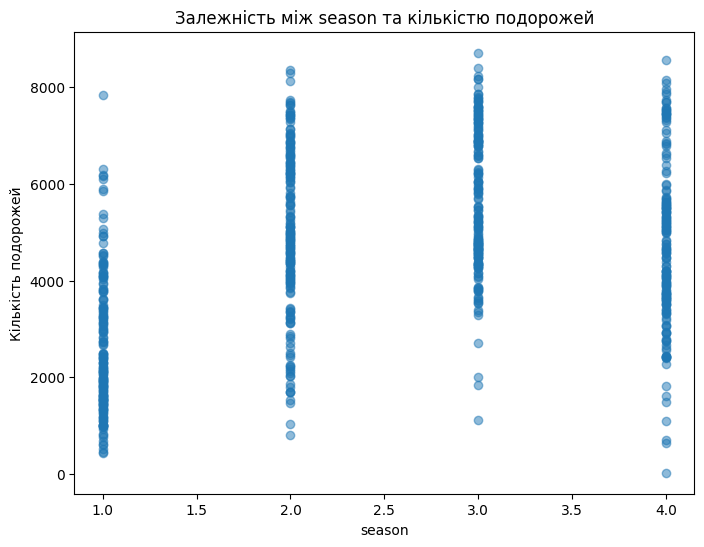

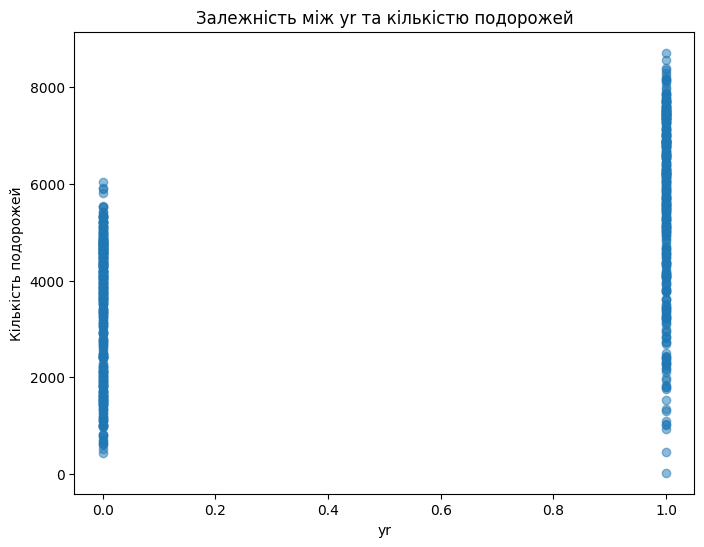

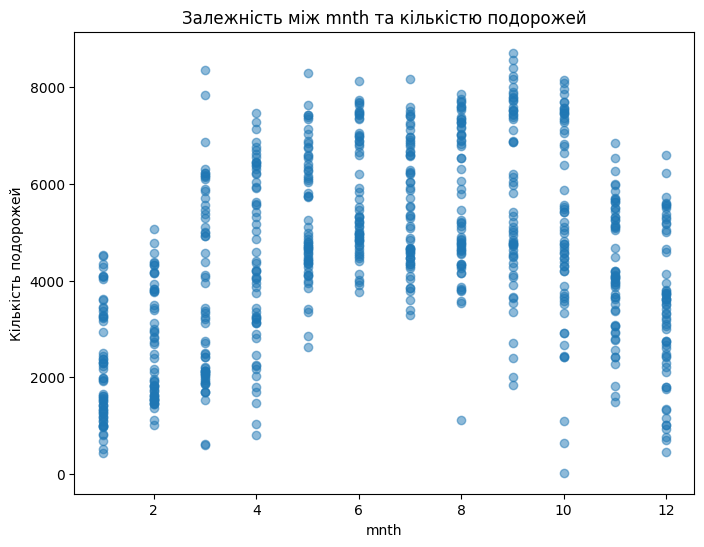

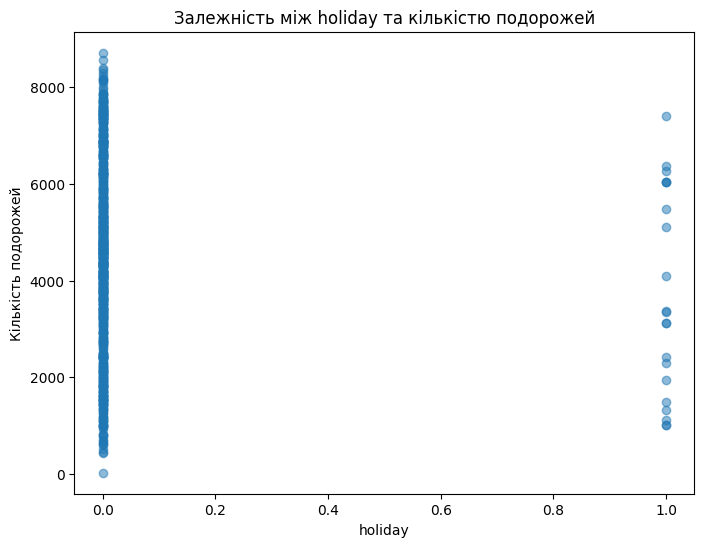

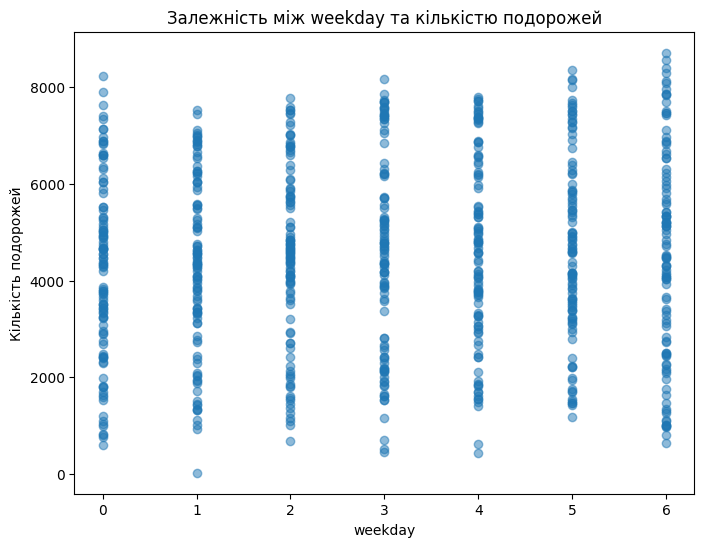

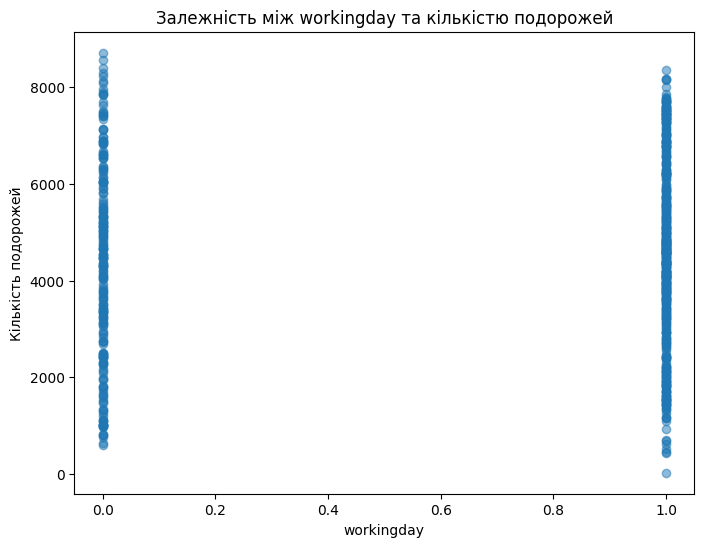

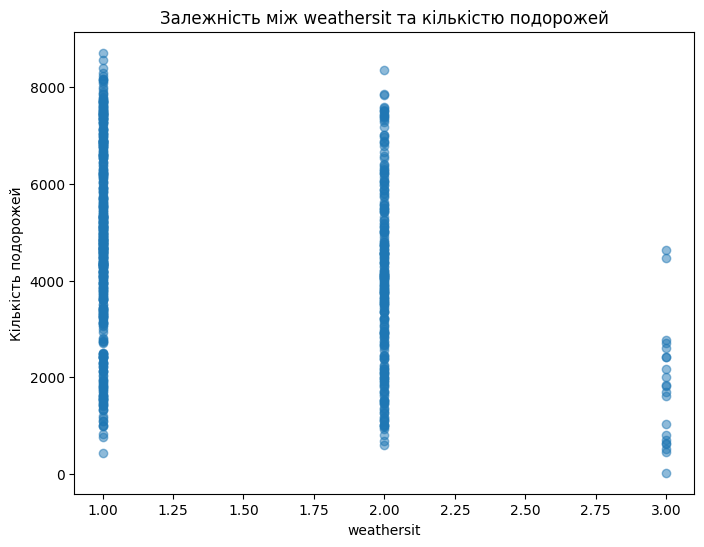

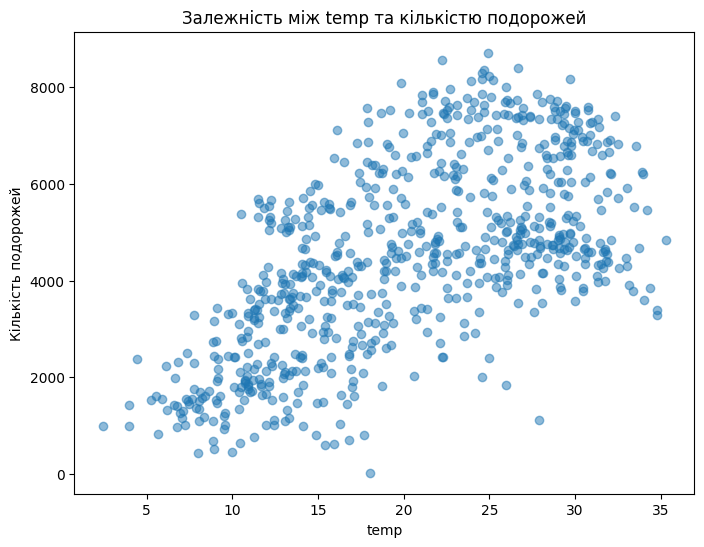

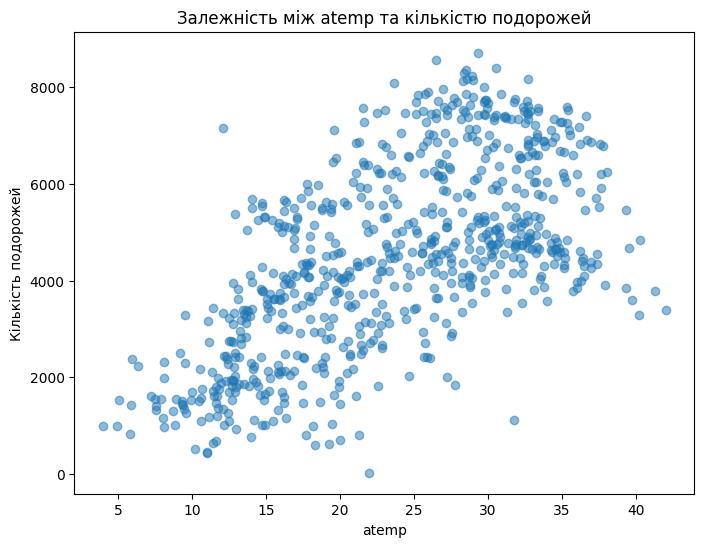

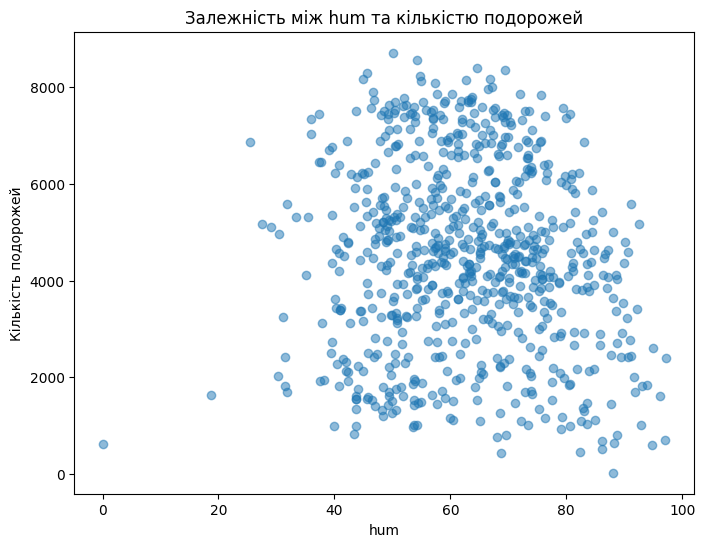

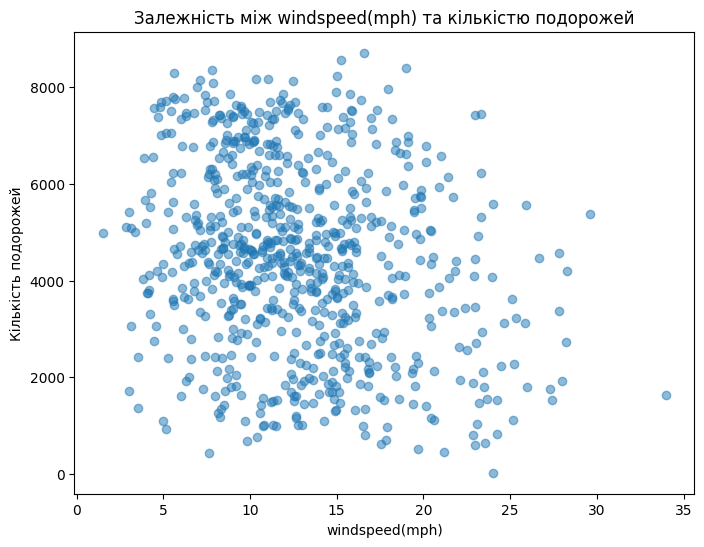

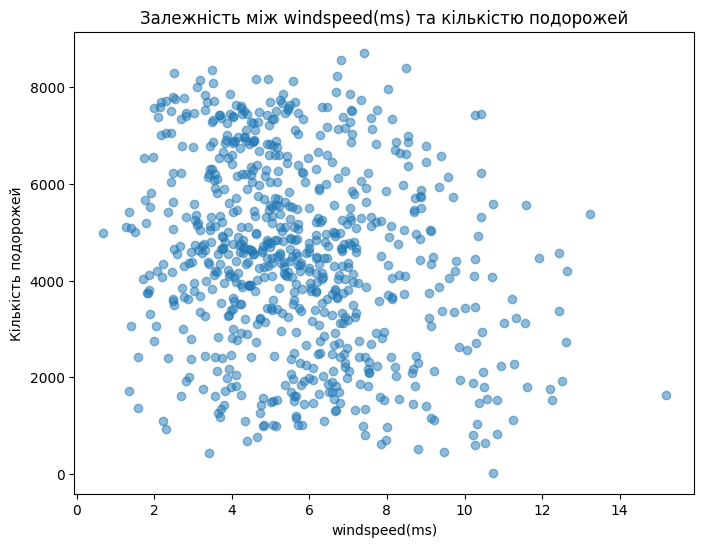

In [7]:
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

for attribute in attributes:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[attribute], df['cnt'], alpha=0.5)
    plt.title('Залежність між {} та кількістю подорожей'.format(attribute))
    plt.xlabel(attribute)
    plt.ylabel('Кількість подорожей')
    plt.show()

Питання:
1. Який характер залежності кількості прокатів від місяця?
1. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно


1. На графіку видно візуальний закономірний зв'язок а саме зростання потім спадання кількості прокатів в залежності від місяця, то можна припустити наявність залежності. Отже характер залежності проявляється у зростанні, а потім спаданні кількості прокатів в залежності від місяця, можна сказати, що ця залежність є лінійною та сезонною.
2. Ознаки, від яких кількість прокатів швидше за все залежить лінійно:
    - atemp: температура по відчуттям у Цельсіях
    - temp: температура у Цельсіях
    - yr: 0 - 2011, 1 - 2012

# Завдання 2

Давайте суворо оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Для її обчислення в pandas можна використовувати методи датафрейму: corr та corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останнім за допомогою методу `corrwith`.

In [11]:
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

По графікам видно, деякі ознаки схожі один на одного. Тому давайте також порахуємо кореляції між дійсними ознаками.

# Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt
за допомогою методу corr:

In [14]:
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

correlations = df[selected_features].corr()

print(correlations)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


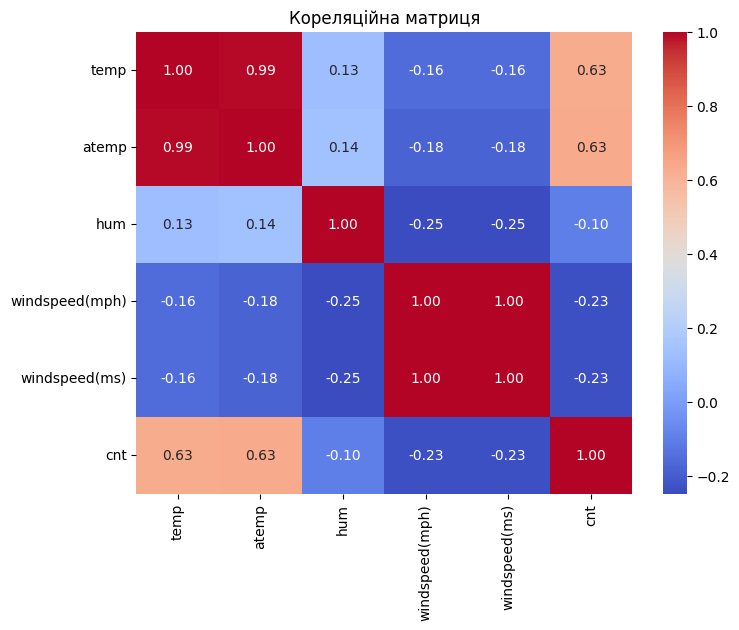

In [15]:
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

correlations = df[selected_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Кореляційна матриця')
plt.show()

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно впливає на навчання лінійної моделі.

# Завдання 4

Виведіть середні ознаки

In [16]:
mean_values = df.mean()
print(mean_values)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо його середнє і поділимо стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це буде потрібно для крос-валідації.

In [17]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [18]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [19]:
from sklearn.linear_model import LinearRegression

# Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються в змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.

In [20]:
reg = LinearRegression().fit(X, y)
[i for i in list(zip(df.columns, reg.coef_))]

[('season', 570.8637960129914),
 ('yr', 1021.9653779400622),
 ('mnth', -141.3017451148728),
 ('holiday', -86.7593446245368),
 ('weekday', 137.22506441350538),
 ('workingday', 56.391881775973005),
 ('weathersit', -330.2264620440312),
 ('temp', 367.48373260182126),
 ('atemp', 585.5493861188597),
 ('hum', -145.61430569885857),
 ('windspeed(mph)', 12457138390688.885),
 ('windspeed(ms)', -12457138390887.346)]

Ми бачимо, що ваги при лінійно-залежних ознаках по модулю значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі у методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим меншим є визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколлінеарності_.

З парою (temp, atemp) трохи менш корелюючих змінних такого не сталося, проте на практиці завжди варто уважно стежити за коефіцієнтами за схожих ознак.

Для того, щоб вирішити проблему мультиколінеарності, потрібно скористатися регуляризатором. До функціонала, що оптимізується, додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

# Завдання 6
Давайте спробуємо навчити лінійні моделі з L_1 і L_2-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за промовчанням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [21]:
from sklearn.linear_model import Lasso, Ridge

In [22]:
lasso = Lasso().fit(X, y)
[i for i in list(zip(df.columns, lasso.coef_))]

[('season', 560.2416160308861),
 ('yr', 1019.4634940657196),
 ('mnth', -128.73062703678696),
 ('holiday', -86.15278133371106),
 ('weekday', 137.34789390496314),
 ('workingday', 55.21237064135668),
 ('weathersit', -332.3698569623487),
 ('temp', 376.3632362096943),
 ('atemp', 576.530793504555),
 ('hum', -144.12915500348583),
 ('windspeed(mph)', -197.1396894024843),
 ('windspeed(ms)', -2.8051404183533485e-08)]

Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги

In [23]:
ridge = Ridge().fit(X, y)
[i for i in list(zip(df.columns, ridge.coef_))]

[('season', 563.0645722520181),
 ('yr', 1018.9483787875305),
 ('mnth', -131.87332028247715),
 ('holiday', -86.74609799709232),
 ('weekday', 138.00511117871918),
 ('workingday', 55.90311037506467),
 ('weathersit', -332.34978849907367),
 ('temp', 386.45788919190807),
 ('atemp', 566.3470470600669),
 ('hum', -145.07132729867195),
 ('windspeed(mph)', -99.25944108179067),
 ('windspeed(ms)', -99.25944115434177)]

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги в список `coefs_ridge'` Конвертуйте отримані списки в `np.array`.

In [31]:
alphas = np.arange(1, 500, 50)

coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

for index, a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    lasso.fit(X, y)
    coefs_lasso[index] = lasso.coef_

for index, a in enumerate(alphas):
    ridge = Ridge(alpha=a)
    ridge.fit(X, y)
    coefs_ridge[index] = ridge.coef_

Проаналізуйте динаміку ваги при збільшенні параметра регуляризації:

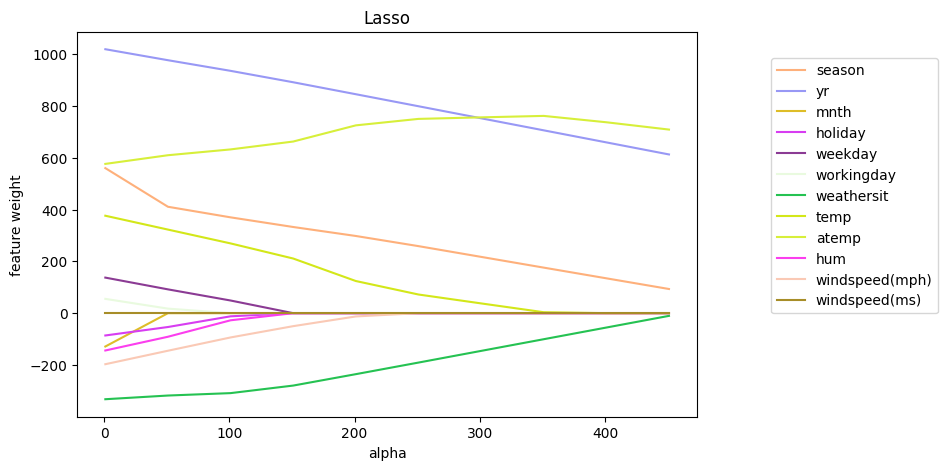

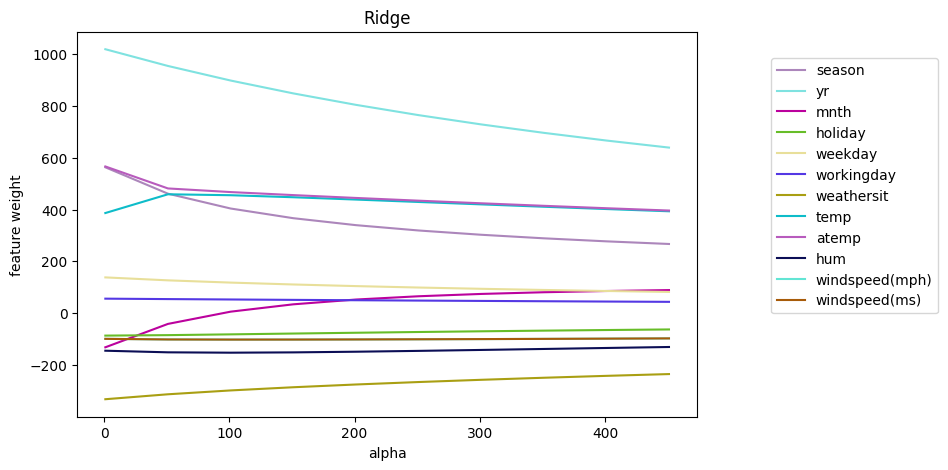

In [26]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповіді:
1.
2.
3.
4.


### Завдання 8

Далі працюватимемо з `Lasso`.

Отже, бачимо, що з зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонал методу найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не …анія на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиття вибірки, на кожному пробувати різні значення alpha, а потім усереднити MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ часто, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а coef\_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [28]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

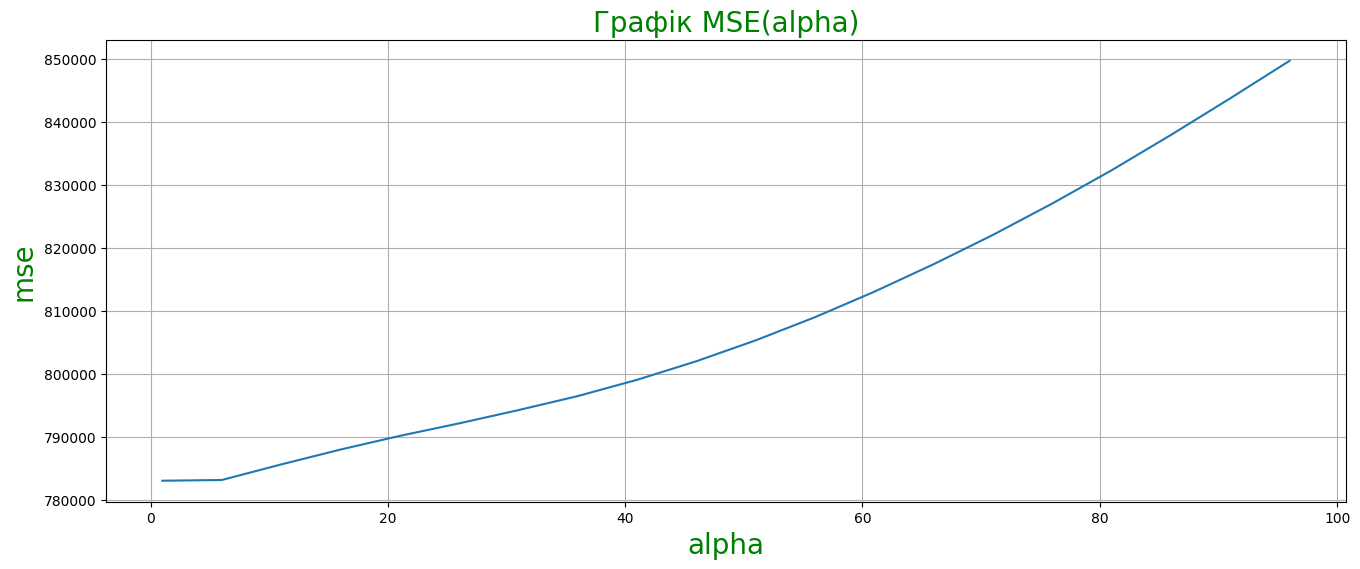

Alpha = 1


[('season', 560.2416160308861),
 ('yr', 1019.4634940657196),
 ('mnth', -128.73062703678696),
 ('holiday', -86.15278133371106),
 ('weekday', 137.34789390496314),
 ('workingday', 55.21237064135668),
 ('weathersit', -332.3698569623487),
 ('temp', 376.3632362096943),
 ('atemp', 576.530793504555),
 ('hum', -144.12915500348583),
 ('windspeed(mph)', -197.1396894024843),
 ('windspeed(ms)', -2.8051404183533485e-08)]

In [29]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor =  LassoCV(alphas=alphas).fit(X, y)

mse = [i.mean() for i in regressor.mse_path_]

plt.rcParams["figure.figsize"] = (16, 6)
plt.plot(regressor.alphas_, mse)
plt.title('Графік MSE(alpha)', fontsize=20, color='g')
plt.xlabel("alpha", fontsize=20, color='g')
plt.ylabel("mse", fontsize=20, color='g')
plt.grid()
plt.show()

print(f'Alpha = {regressor.alpha_}')
[i for i in list(zip(df.columns, regressor.coef_))]

Отже, ми вибрали певний параметр регулювання. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбиття (тобто по стовпцях).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.

Alpha = 1, MSE = 691447.250787807
Alpha = 11, MSE = 883471.1829425395
Alpha = 1, MSE = 710110.1624117332
Alpha = 26, MSE = 860737.405948872
Alpha = 21, MSE = 750676.356779


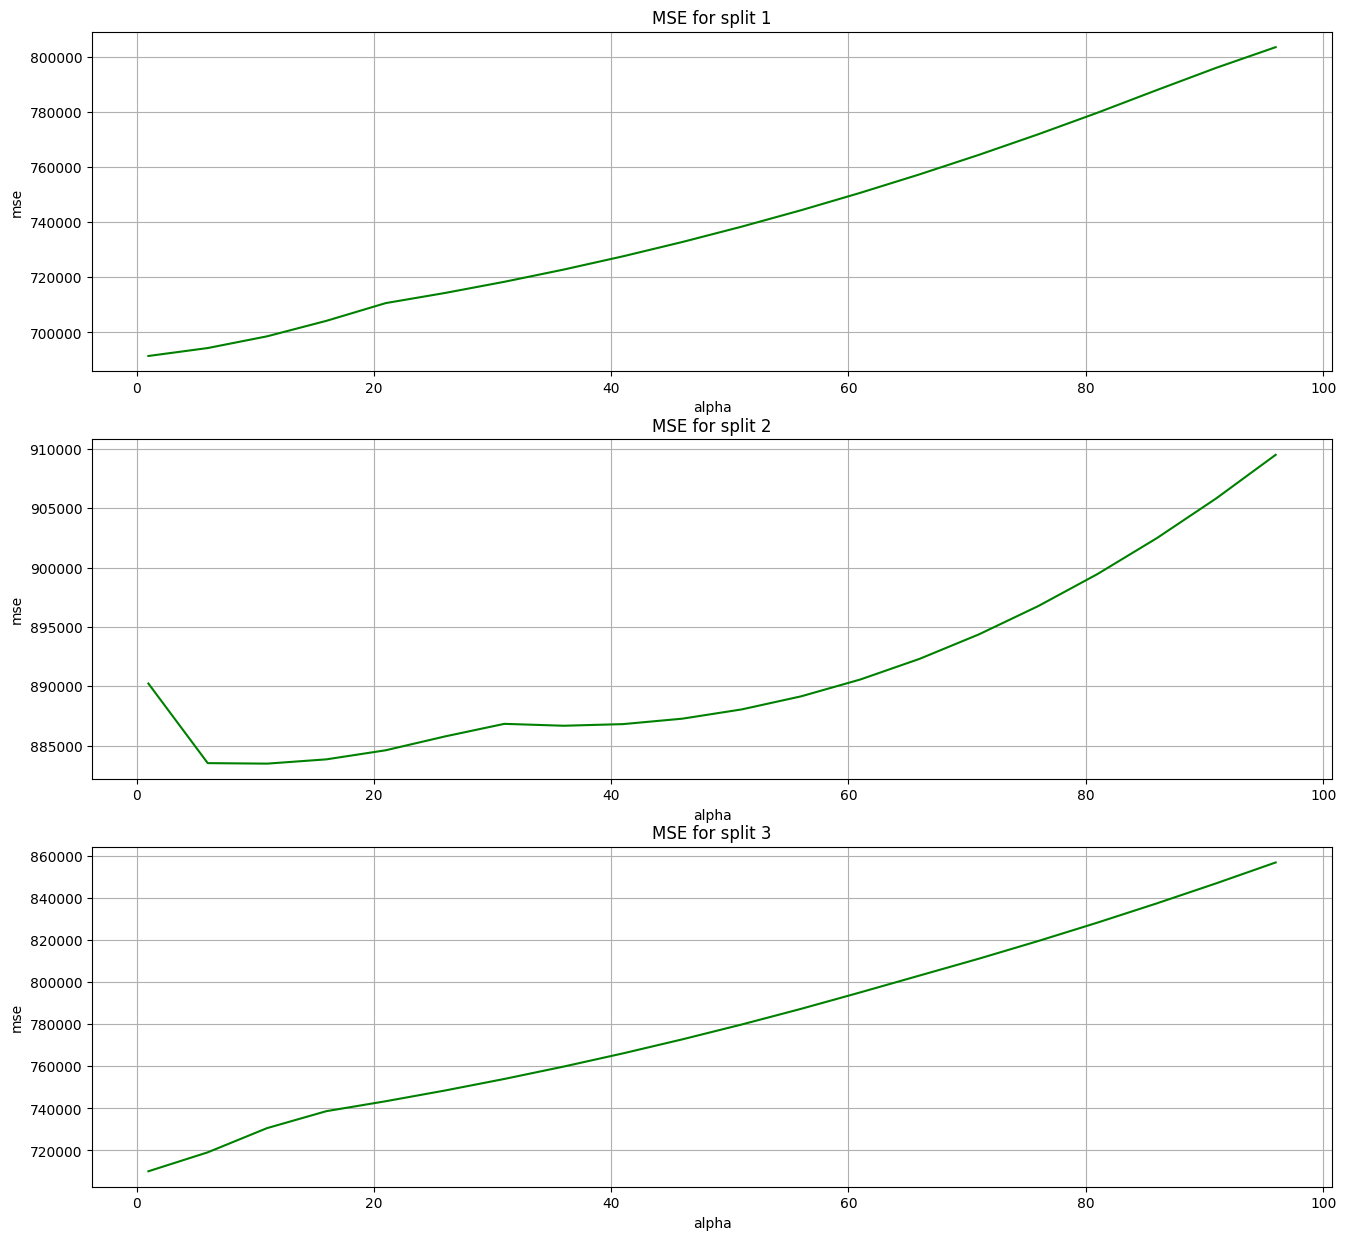

In [30]:
for i in range(3):
    plt.rcParams["figure.figsize"] = (16, 15)
    plt.subplot(3, 1, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], c='g')
    plt.title(f'MSE for split {i+1}')
    plt.xlabel('alpha')
    plt.ylabel('mse')
    plt.grid()

for alpha, mse in enumerate(np.min(regressor.mse_path_, axis=0)):
    alpha_min = regressor.mse_path_[:, alpha].argmin(axis=0)
    print(f'Alpha = {regressor.alphas_[alpha_min]}, MSE = {mse}')

На кожному розбиття оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиття. Виходить, що ми налаштовуємось на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиття вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на наступні запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Відповідь:
1.  Чи видно зростаючу лінійну залежність cnt від цих ознак за графіками?

Графік 1: Залежність від температури (temp)
На графіку видно, що кількість прокатів зазвичай зростає зі збільшенням температури. Однак ця залежність може мати не тільки лінійний, але і нелінійний характер, зокрема.

Графік 2: Залежність від відчутної температури (atemp)
Графік відчутної температури показує схожу тенденцію, але може бути трохи меншою за амплітудою залежність. Це теж може мати нелінійний характер.

Графік 3: Залежність від вологості (hum)
На цьому графіку здавалося б, що немає чіткої лінійної залежності між вологостію та кількістю прокатів. Проте можливо існує слабка негативна лінійна залежність при високих значеннях вологості, де кількість прокатів дещо менша.

Графік 4: Залежність від швидкості вітру в милях на годину (windspeed(mph))
Графік показує слабку позитивну лінійну залежність: зі збільшенням швидкості вітру кількість прокатів зростає, але ця залежність слабка.

Загальний висновок: Лінійність залежностей на графіках не є дуже вираженою. Це може вказувати на те, що лінійна модель (яка базується на лінійних залежностях) може бути не найкращим вибором для прогнозування кількості прокатів на основі цих ознак.

2.  Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Зі здорового глузду можна стверджувати, що температура може впливати на бажання людей користуватися велосипедами. Зазвичай в людей зростає бажання взяти велосипеди, коли температура стає приємною, тобто в теплу погоду.

Щодо відчутної температури, вона також може бути важливою, оскільки вона враховує вплив вітру та вологості на відчуття тепла. Таким чином, відчутна температура також може впливати на бажання взяти велосипеди.

Проте вологість та швидкість вітру мають слабший вплив на бажання користуватися велосипедами, і на графіках не виражено чіткої лінійної залежності.

Загалом, хоча існує певний вплив погодних умов на попит на велосипеди, ці взаємозв'язки є складними та можуть бути не тільки лінійними.



4 ознаки з найбільшими позитивними коефіцієнтами: Index(['yr', 'atemp', 'season', 'temp'], dtype='object')


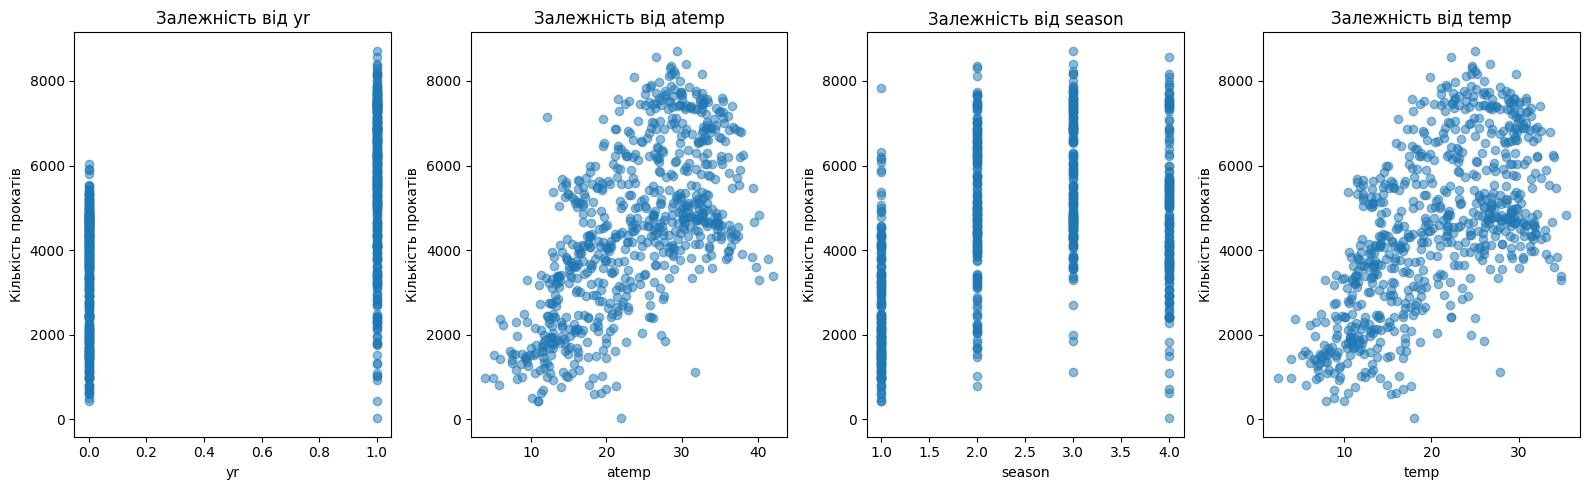

In [34]:
top_features_indices = regressor.coef_.argsort()[-4:][::-1]

top_features = df.columns[top_features_indices]

print("4 ознаки з найбільшими позитивними коефіцієнтами:", top_features)

plt.figure(figsize=(16, 5))
for i, feature in enumerate(top_features, 1):
    plt.subplot(1, 4, i)
    plt.scatter(df[feature], df['cnt'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Кількість прокатів')
    plt.title(f'Залежність від {feature}')
plt.tight_layout()
plt.show()

#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться відповідні візуалізації. Чи видно лінійну залежність, яка зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

Відповідь:
1. Чи видно лінійну залежність, яка зменшується?

На графіках залежності кількості прокатів від ознак, які мають найменші за модулем негативні коефіцієнти, лінійна залежність не виглядає очевидною. Графіки не демонструють чіткої лінійної зменшуючоїся тенденції.

2. Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

Із наведених ознак:

workingday (робочий день): Ця ознака вказує, чи є день робочим (1) або вихідним (0). За логікою, вихідні можуть призвести до більшого бажання взяти велосипеди для відпочинку або розваги, отже, може бути навпаки - у вихідні дні більше людей можуть хотіти взяти велосипеди.

holiday (свято): Ця ознака вказує, чи є свято (1) чи ні (0). Схоже, що вихідні і свята можуть сприяти більшому попиту на велосипеди, тому негативний коефіцієнт може бути неочікуваним.

season (сезон): Ця ознака вказує на сезон (1 - весна, 2 - літо, 3 - осінь, 4 - зима). В залежності від погодних умов, сезон може впливати на бажання користувачів взяти велосипед. Літні місяці можуть бути більш привабливими для прокату велосипедів, тому негативний коефіцієнт може здатися несподіваним.

Отже, за контекстом цих ознак і їхнім впливом на бажання взяти велосипеди, логічності у висновку про зменшення кількості прокатів при збільшенні значень цих ознак не виявлено.

#### Питання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви вважаєте, чому модель виключила їх із моделі (знов подивіться на графіки)? Чи правда, що вони не впливають на попит на велосипеди?

Відповідь:
1. Коли модель лінійної регресії навчається на даних, вона намагається знайти оптимальний набір ваг для кожної ознаки таким чином, щоб найкращим чином передбачити цільову змінну (у цьому випадку, кількість прокатів велосипедів). Якщо вага для конкретної ознаки наближається до нуля (або стає надзвичайно малим), це означає, що ця ознака майже не впливає на прогнозоване значення цільової змінної.

2. Ні, низькі або нульові коефіцієнти в лінійній регресійній моделі не обов'язково означають, що відповідні ознаки не впливають на попит на велосипеди. Вони лише вказують на те, що ці ознаки не вносять суттєвого вкладу в прогнозування в межах конкретної моделі.

In [67]:
# Визначимо ознаки з коефіцієнтами, близькими до нуля
near_zero_coefficients = [col for col, coef in zip(df.columns, regressor.coef_) if abs(coef) < 1e-3]

# Виведемо ці ознаки та їхні коефіцієнти
for feature, coefficient in zip(df.columns, regressor.coef_):
    if feature in near_zero_coefficients:
        print(f"{feature}: {coefficient:.4f}")

# Кількість ознак у датасеті
total_features = len(df.columns)

# Кількість ознак з нульовими (або дуже близькими до нуля) коефіцієнтами
zero_coefficient_features = len(near_zero_coefficients)

print(f"Загальна кількість ознак: {total_features}")
print(f"Кількість ознак з нульовими коефіцієнтами: {zero_coefficient_features}")
print(f"Відсоток виключених ознак: {(zero_coefficient_features / total_features) * 100:.2f}%")
print(f"regressor.coef_: {regressor.coef_}")

windspeed(ms): -0.0000
Загальна кількість ознак: 13
Кількість ознак з нульовими коефіцієнтами: 1
Відсоток виключених ознак: 7.69%
regressor.coef_: [ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
  1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
  5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]


### Висновок
напишіть висновок

In [ ]:
У цій роботі ми вивчили датасет, що містить інформацію про прокат велосипедів. Проведено аналіз залежностей кількості прокатів від різних ознак, таких як місяць, температура, погодні умови та інші.

Аналіз залежності від місяця:
Ми визначили, що кількість прокатів має відмітний сезонний характер: зростає в теплі місяці та зменшується в холодні.

Лінійна залежність:
Ми побудували лінійну регресійну модель для прогнозування кількості прокатів на основі різних ознак. Деякі ознаки мали суттєвий вплив на прогнози (наприклад, температура), тоді як інші мали низькі або нульові коефіцієнти, що може вказувати на їхню меншу важливість для моделі.

Модельні обмеження:
Важливо враховувати, що лінійна модель може бути недостатньою для врахування складних нелінійних залежностей у даних. Деякі ознаки можуть мати низькі коефіцієнти через недостатню складність моделі або через їхню нелінійність, що може призвести до переоцінки їх впливу.

Мультиколінеарність:
Мультиколінеарність, тобто взаємна кореляція між ознаками, може призводити до невизначеності в оцінці коефіцієнтів. Це може бути однією з причин, чому деякі ознаки мали низькі коефіцієнти.

Усі ці фактори важливо враховувати при інтерпретації результатів моделі та використанні її для прогнозування. Без врахування контексту та особливостей даних можна зробити неправильні висновки щодо впливу ознак на попит на велосипеди.